In [9]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import Image
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set_style('darkgrid')

# Multi-attribute labels: gender and hair color

class indices:
black hair = 8
gender = 20

### Build new labels

In [ ]:
DATA_DIR = '/path/to/data/'

In [11]:
# make sure to have pre-processed the celebA dataset before running this code!
split = 'test'
data = torch.load(os.path.join(DATA_DIR, '{}_celeba_64x64.pt'.format(split)))
labels = torch.load(os.path.join(DATA_DIR, '{}_labels_celeba_64x64.pt'.format(split)))

In [12]:
new_labels = np.zeros(len(labels))
unique_items = np.unique(labels[:,(8, 20)], axis=0)
for i, unique in enumerate(unique_items):
    yes = np.ravel([np.array_equal(x,unique) for x in labels[:,(8,20)]])
    new_labels[yes] = i
    print(unique, i)

[0. 0.] 0
[0. 1.] 1
[1. 0.] 2
[1. 1.] 3


In [96]:
new_labels = torch.from_numpy(new_labels)
torch.save(new_labels, os.path.join(DATA_DIR, '{}_multi_labels_celeba_64x64.pt'.format(split)))

### breakdown:
- black hair = 0, male = 0 -> 0
- black hair = 0, male = 1 -> 1
- black hair = 1, male = 0 -> 2
- black hair = 1, male = 1 -> 3

### test label and image consistency

In [100]:
split = 'train'
data = torch.load(os.path.join(DATA_DIR, '{}_celeba_64x64.pt'.format(split)))
labels = torch.load(os.path.join(DATA_DIR, '{}_multi_labels_celeba_64x64.pt'.format(split)))

In [99]:
for i in range(4):
    print(i, np.where(labels.data.cpu().numpy()==i)[0][0:5])

0 [0 1 3 4 5]
1 [ 2 12 14 15 20]
2 [10 13 16 26 34]
3 [ 6  7 11 19 32]


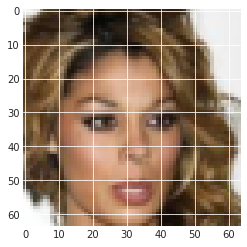

tensor(0., dtype=torch.float64)


In [111]:
i = 5
plt.imshow(np.transpose(data[i].data.cpu().numpy(), (1,2,0)))
plt.show()
print(labels[i])

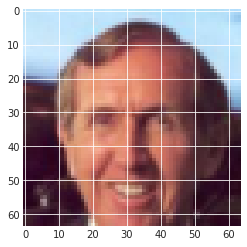

tensor(1., dtype=torch.float64)


In [115]:
i = 20
plt.imshow(np.transpose(data[i].data.cpu().numpy(), (1,2,0)))
plt.show()
print(labels[i])

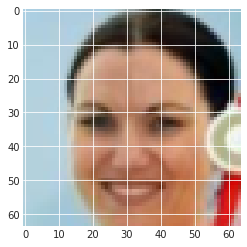

tensor(2., dtype=torch.float64)


In [107]:
i = 16
plt.imshow(np.transpose(data[i].data.cpu().numpy(), (1,2,0)))
plt.show()
print(labels[i])

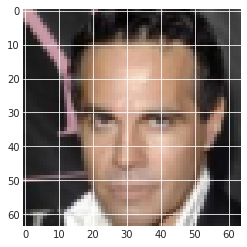

tensor(3., dtype=torch.float64)


In [105]:
i = 7
plt.imshow(np.transpose(data[i].data.cpu().numpy(), (1,2,0)))
plt.show()
print(labels[i])

### Construct splits

train set
- balanced dataset ratio: (array([0., 1., 2., 3.]), array([15000, 15000, 15000, 15000]))
- unbalanced dataset ratio: (array([0., 1., 2., 3.]), array([26216, 24878,  3784,  5122]))

validation set

- balanced dataset ratio: (array([0., 1., 2., 3.]), array([1315, 1315, 1315, 1315]))
-unbalanced dataset ratio: (array([0., 1., 2., 3.]), array([ 973, 1091,  342,  224]))

new labels:
- 0) (black hair = 0, male = 0): 26216
- 1) (black hair = 0, male = 1): 24878
- 2) (black hair = 1, male = 0): 3784
- 3) (black hair = 1, male = 1): 5122

In [1]:
(26216 + 24878 + 3784 + 5122)

60000

In [11]:
26216/ 60000

0.43693333333333334

In [12]:
24878/ 60000

0.41463333333333335

In [13]:
3784 / 60000

0.06306666666666666

In [14]:
5122 / 60000

0.08536666666666666

--------

# Prepare samples for unbiased FID statistic calculation

## Single-attribute

In [69]:
labels[:,20]

tensor([0., 0., 1.,  ..., 1., 1., 0.], dtype=torch.float64)

combine all data across splits to maximize number of samples

In [22]:
splits = ['test', 'val', 'train']

In [23]:
data = []
labels = []
for split in splits:
    d = torch.load(os.path.join(DATA_DIR, '{}_celeba_64x64.pt'.format(split)))
    l = torch.load(os.path.join(DATA_DIR, '{}_labels_celeba_64x64.pt'.format(split)))
    data.append(d)
    labels.append(l)

In [24]:
data = torch.cat(data)
labels = torch.cat(labels)

In [25]:
# get minimum value of class
val, freq = np.unique(labels[:,20].data.numpy(), return_counts=True)
min_value = min(freq)
print(val, freq)
print(min(freq))

samples = []
ys = []
for i in range(len(val)):
    idx = np.where(labels[:,20].data.numpy() == i)[0][0:min_value]
    samples.append(data[idx])
    ys.append(labels[:,20][idx])

[0. 1.] [118165  84434]
84434


In [26]:
84434 * 2

168868

In [27]:
len(samples)

2

In [28]:
samples[0].shape

torch.Size([84434, 3, 64, 64])

In [29]:
samples[1].shape

torch.Size([84434, 3, 64, 64])

In [30]:
samples = torch.cat(samples)
samples = samples.numpy()
samples.shape

In [33]:
# now we should convert to numpy
samples = np.transpose(samples, (0, 2, 3, 1))

In [34]:
samples.shape

(168868, 64, 64, 3)

In [35]:
np.savez('../fid_stats/unbiased_all_gender_samples.npz', **{'x':samples})

## Multi-attribute

In [36]:
splits = ['test', 'val', 'train']

In [40]:
# multi
data = []
labels = []
for split in splits:
    d = torch.load(os.path.join(DATA_DIR, '{}_celeba_64x64.pt'.format(split)))
    l = torch.load(os.path.join(DATA_DIR, '{}_multi_labels_celeba_64x64.pt'.format(split)))
    data.append(d)
    labels.append(l)

In [41]:
data = torch.cat(data)
labels = torch.cat(labels)

In [42]:
# get minimum value of class
val, freq = np.unique(labels.data.numpy(), return_counts=True)
min_value = min(freq)
print(val, freq)
print(min(freq))

samples = []
ys = []
for i in range(len(val)):
    idx = np.where(labels.data.numpy() == i)[0][0:min_value]
    samples.append(data[idx])
    ys.append(labels[idx])

[0. 1. 2. 3.] [94849 59278 23316 25156]
23316


In [6]:
23316*4

93264

In [43]:
samples = torch.cat(samples)
samples = samples.numpy()
samples.shape

(93264, 3, 64, 64)

In [44]:
# now we should convert to numpy
samples = np.transpose(samples, (0, 2, 3, 1))

In [46]:
np.savez('../fid_stats/unbiased_all_multi_samples.npz', **{'x':samples})